In [1]:
import sys
import os
import numpy as np
from scipy import signal
import abel
import matplotlib
from matplotlib import pyplot as plt, patches
import matplotlib.image as mpimg
from PIL import Image
from scipy import ndimage
from skimage.restoration import unwrap_phase
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [7]:
def draw_fft(ax,data, fx,fy, bands,method='l',peak_threshold=99.99,vmax = 0):
    print('begin draw_fft');
    data_fft = np.fft.fftn(data);
    data_fft_shifted = np.fft.fftshift(data_fft)
    if method =='l':
        pass;
    else:
        pass;
    ax.set_title('Amplitude spectrum')
    print('data_fft_shifted_shape is :',data_fft_shifted.shape)
    xfreq = np.fft.fftshift(np.fft.fftfreq(data_fft_shifted.shape[1]))
    yfreq = np.fft.fftshift(np.fft.fftfreq(data_fft_shifted.shape[0]))
    if vmax == 0 :
        vmax = np.percentile(np.abs(data_fft_shifted), peak_threshold)
        print("vmax=", vmax)
    ax.pcolormesh(xfreq, yfreq, np.abs(data_fft_shifted), vmax=vmax)
    ax.set_xlim(-0.1,0.1)
    ax.set_ylim(-0.1,0.1)
    if bands :
        rect = patches.Rectangle((fx-bands[0], fy-bands[1]), 2*bands[0], 2*(bands[1]),\
         linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    xx,yy = np.meshgrid(xfreq,yfreq)
    
    #对选定区域的mask进行逆fft变换
    mask = (xx > fx-bands[0])*(xx < fx+bands[0])*(yy > (fy-bands[1]))*(yy < fy + bands[1])
    data_fft_shifted_mask = data_fft_shifted.copy()*mask
    
    return xfreq,yfreq,data_fft,data_fft_shifted,data_fft_shifted_mask

In [8]:
def draw_ifft(ax,data_fft_shifted):
    #对逆FFT的结果进行反演变化
    ifft_data = np.fft.ifftn(np.fft.ifftshift(data_fft_shifted))
    ax.imshow(ifft_data.real)
    ax.set_title('the mask IFFT image')

In [9]:
def abel_reverse(filename='',filename_base='',fx = 0.00,fy = 0.1,bands=[0.01,0.01],crop=10):

    data = np.array(Image.open(filename))

    ny,nx = data.shape
    #-----------------------Figure 1
    figure = plt.figure(figsize=(20,16))
    ax = figure.add_subplot(341)
    ax.imshow(data)


    #-----------------------Figure 2
    ax.set_title('Interferogram')
    ax = figure.add_subplot(342)
    xfreq,yfreq,data_fft,data_fft_shifted,data_fft_shifted_mask = draw_fft(ax = ax,data = data,fx = fx,fy = fy,bands = bands)


    #-----------------------Figure 3
    ax = figure.add_subplot(343)
    phase2 = np.angle(np.fft.ifftn(np.fft.ifftshift(data_fft_shifted_mask)))
    ax.imshow(phase2)
    ax.set_title('Phase')

    #-----------------------Figure 4
    ax = figure.add_subplot(344)
    #由于相位在-pi到pi之间振荡，我们需要将其unwrapped，变为非振荡项
    ax.set_title('Unwrapped phase')
    crop = 20
    phase_modify = unwrap_phase(phase2)
    ax.imshow(phase_modify)


    #对base图片做同样的操作
    base_data = np.array(Image.open(filename_base))
    ny,nx = base_data.shape

    #-----------------------Figure 5
    ax = figure.add_subplot(345)
    ax.imshow(base_data)
    ax.set_title('Reference')

    #对参考图样做傅里叶变换

    #-----------------------Figure 6
    ax=figure.add_subplot(346)
    x1,y1,basedata_fft,basedata_fft_shifted,basedata_fft_shifted_mask = draw_fft(ax = ax,data = base_data,fx = fx,fy = fy,bands = bands)

    #逆傅里叶变换
    #-----------------------Figure 7
    ax=figure.add_subplot(347)
    phase_ref = np.angle(np.fft.ifftn(np.fft.ifftshift(basedata_fft_shifted_mask)))
    ax.imshow(phase_ref)
    ax.set_title('Phase—reference')

    #进行相位变换
    #-----------------------Figure 8
    ax=figure.add_subplot(348)
    phase_ref_modify = unwrap_phase(phase_ref)
    ax.imshow(phase_ref_modify)
    ax.set_title('Unwrap phase reference')

    #相减得到相位差
    #-----------------------Figure 9
    ax = figure.add_subplot(349)
    phase_delta = abs(phase_modify - phase_ref_modify)
    ax.imshow(phase_delta,cmap='jet')
    ax.set_title('Phase Difference')

    #对数密度进行反演，利用逆Abel变换
    #-----------------------Figure 10
    ax = figure.add_subplot(3,4,10)
    ax.set_title(r'$\Delta \ \eta$')

    #Flip the image
    image = phase_delta.T/2/np.pi


    inverse_abel = abel.Transform(image, method='three_point', direction='inverse', center='convolution',
                                  symmetrize_method='average',verbose=True, symmetry_axis=0,
                                 center_options={"axis" : 1, "verbose" : True}).transform.T

    inverse_abel[inverse_abel < 0 ] = 0.0
    crop = 20
    im = ax.imshow(inverse_abel[crop:-crop,crop:-crop],cmap = plt.cm.jet, vmin=0,vmax=0.05)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)

    figure.colorbar(im, cax=cax, orientation='vertical')
    #计算折射率
    #-----------------------Figure 11
    ax = figure.add_subplot(3,4,11)
    ax.set_title('refraction')

    eta = 1 - inverse_abel[crop:-crop,crop:-crop]
    im = ax.imshow(eta,cmap = plt.cm.jet)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    figure.colorbar(im, cax=cax, orientation='vertical')

    #计算数密度
    wavelength = 0.547 # μm
    nc = 1.1e21/((wavelength)**2)*1e6 #转为 m^-3

    ne = nc * ( 1- eta**2)

    ax = figure.add_subplot(3,4,12)
    im = ax.imshow(ne,cmap = plt.cm.jet)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    figure.colorbar(im, cax=cax, orientation='vertical')

    #电子半径
    # r_e = 2.81794e-15 #m
    # sizePerPixel = 2.56*1e-6 #m
    # Ne = inverse_abel / (r_e * wavelength*1e-6 * sizePerPixel)
    # ax = figure.add_subplot(3,4,12)

    # IM,ne,AIM = get_abel(phase=image,xcenter = 200,method = 'hansenlaw',gfactor = 1.0,wavelength = 527e-9)
    # ax.imshow(Ne,cmap = plt.cm.seismic)

    ax.set_title('Ne')
    
    return phase_delta,ne



begin draw_fft
data_fft_shifted_shape is : (435, 850)
vmax= 320512.70110347535
begin draw_fft
data_fft_shifted_shape is : (435, 850)
vmax= 764550.9737776085
delta = (-160.0, -18.0)


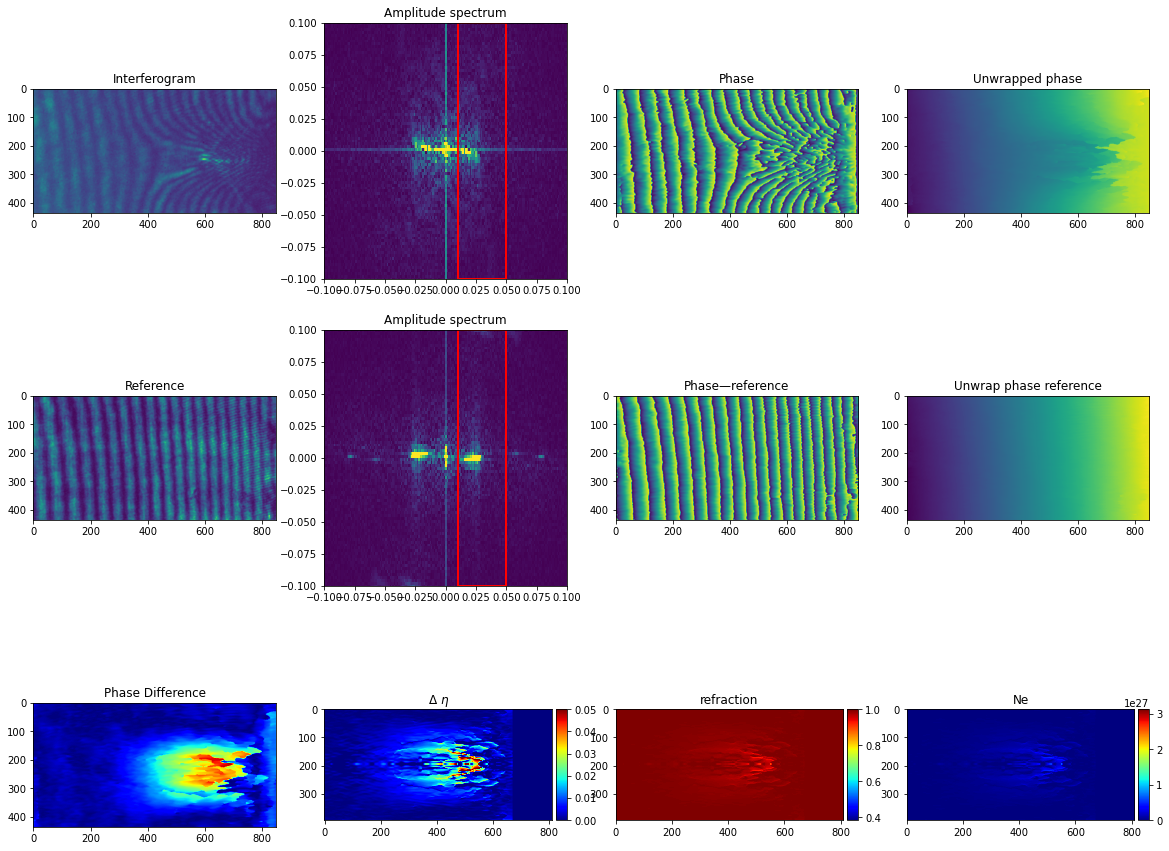

In [14]:
phase_delta_oneside,ne_oneside = abel_reverse(filename='acc_oneside_data_cut.tif',
                                              filename_base='acc_oneside_data_back_cut.tif',
                                              fx = 0.03,fy = 0.0,bands=[0.02,0.1],crop=10)

begin draw_fft
data_fft_shifted_shape is : (200, 450)
vmax= 22859489.15965914
begin draw_fft
data_fft_shifted_shape is : (200, 450)
vmax= 53208607.921637654
delta = (0.5, 0.0)


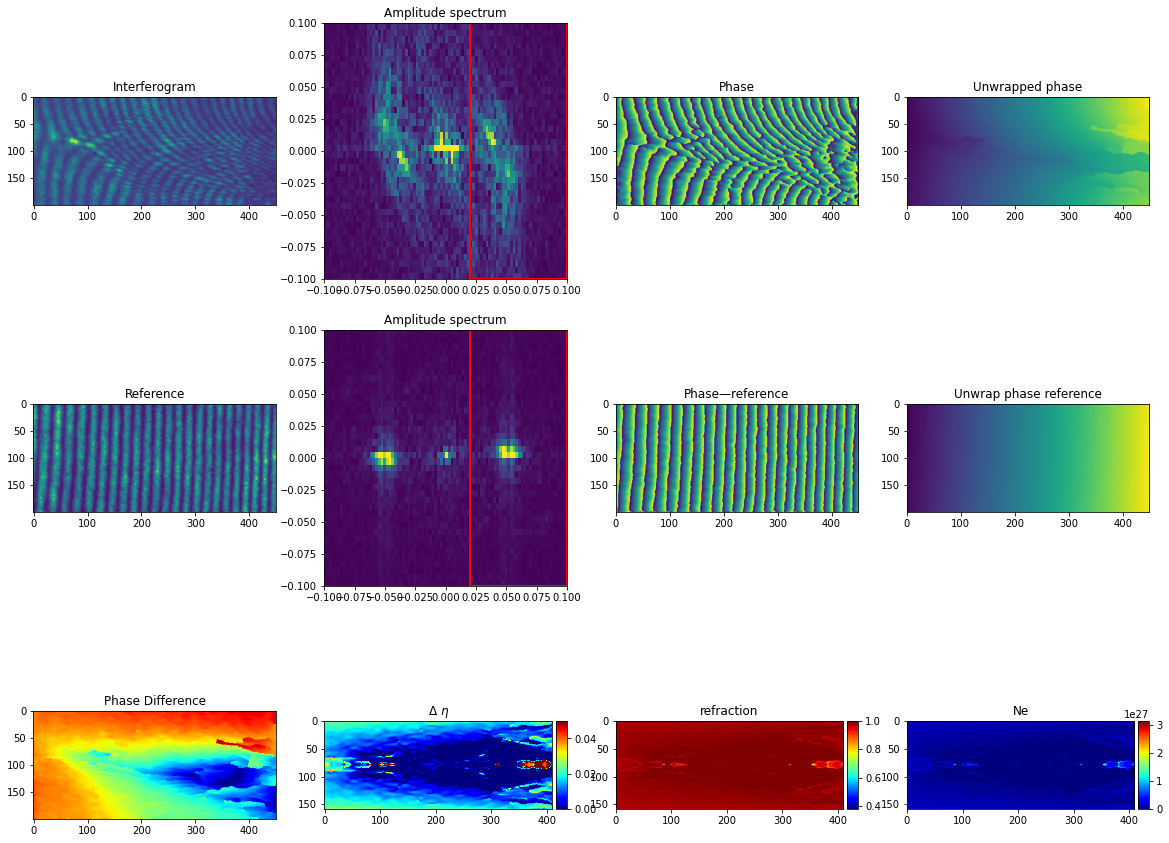

In [38]:
phase_delta_twoside,ne_twoside = abel_reverse(filename='20200829009_ganshe_cut.tif',
                                              filename_base='20200829009_ganshe_back_cut.tif',
                                              fx = 0.06,fy = 0.0,bands=[0.04,0.1],crop=10)

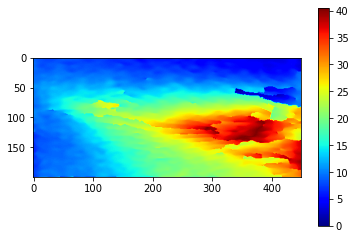

In [42]:
plt.imshow(abs(phase_delta_twoside - phase_delta_twoside.max()),cmap='jet')
plt.colorbar()

In [68]:
4.54*670

3041.8

begin draw_fft
data_fft_shifted_shape is : (435, 670)
vmax= 293735.45061449485
begin draw_fft
data_fft_shifted_shape is : (435, 670)
vmax= 716572.4754528797
delta = (0.5, 0.0)


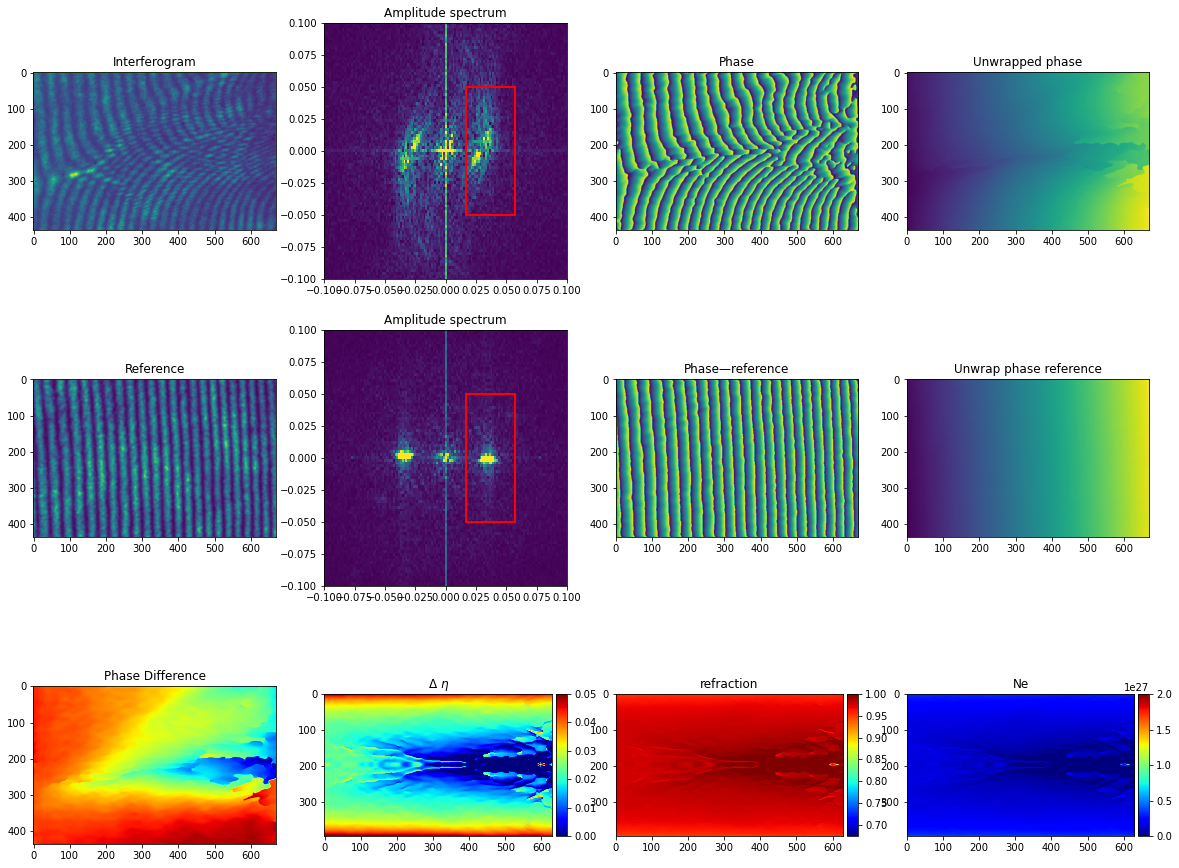

In [43]:
phase_delta_twoside_2,ne_twoside = abel_reverse(filename='acc_twoside_data_cut.tif',
                                              filename_base='acc_twoside_back_cut.tif',
                                              fx = 0.037,fy = 0.0,bands=[0.02,0.05],crop=10)

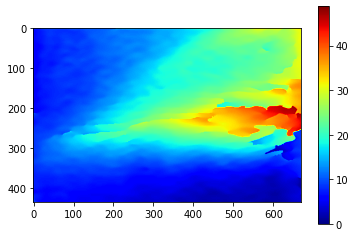

In [44]:
plt.imshow(abs(phase_delta_twoside_2 - phase_delta_twoside_2.max()),cmap='jet')
plt.colorbar()

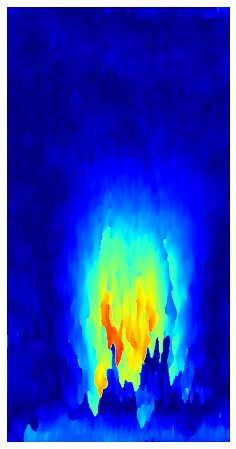

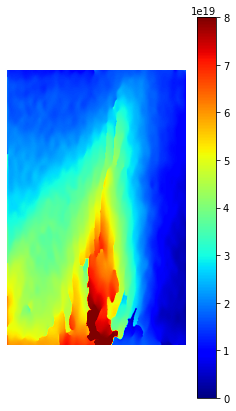

In [69]:
wavelength = 0.527
nc = 1.1e21/wavelength**2
phase_delta_twoside = abs(phase_delta_twoside_2 - phase_delta_twoside_2.max())
ne_oneside = 2*phase_delta_oneside*nc*wavelength/400/2/2
ne_twoside = 2*phase_delta_twoside*nc*wavelength/363/2/3
plt.figure(figsize=(4,8))
plt.imshow(ne_oneside.T,cmap='jet',vmax=8e19)
plt.axis('off')
plt.savefig('reve_ne_oneside.tif',dpi=200)

plt.figure(figsize=(4,7))
plt.imshow(ne_twoside.T,cmap='jet',vmax=8e19)
plt.axis('off')
plt.colorbar()
plt.savefig('reve_ne_twosidewith_bar.eps',dpi=200)

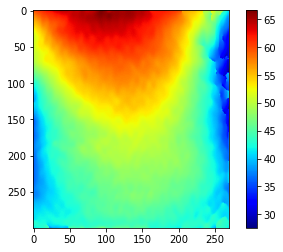

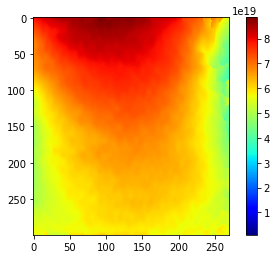

In [142]:
plt.figure()
plt.imshow(phase_delta,cmap='jet')
plt.colorbar()

wavelength = 0.527
nc = 1.1e21/wavelength**2

D = phase_delta/(2*np.pi)

L = 500

ne = 2*D*nc * wavelength / L
plt.figure()
plt.imshow(ne,cmap='jet',vmin=1e18)
plt.colorbar()

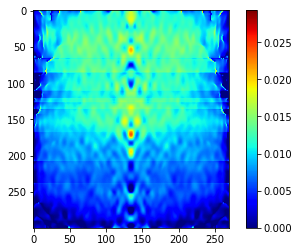

In [119]:
test = inverse_abel.copy()
test[test < 0 ] = 0
plt.imshow(test[:,:],cmap='jet',vmin=0)
plt.colorbar()

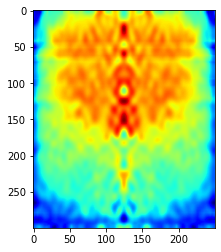

In [78]:
import cv2
blurred = np.hstack([cv2.GaussianBlur(inverse_abel,(9,9),9)
                     ])
plt.imshow(blurred,cmap='jet')

In [28]:
ImRed_half = ((ImRed[:,round(len(ImRed[0])/2):len(ImRed[0])]+np.flip(ImRed[:,0:round(len(ImRed[0])/2)+1], axis=1)) / 2)

(300, 251)

(array([[  0.,   0.,   0., ...,   2., 296.,   2.],
        [  0.,   0.,   0., ...,   1., 297.,   2.],
        [  0.,   0.,   0., ...,   0., 299.,   1.],
        ...,
        [  5.,   6.,  25., ...,  35.,  75.,  68.],
        [  5.,   6.,  21., ...,  35.,  74.,  69.],
        [  5.,   6.,  21., ...,  35.,  72.,  71.]]),
 array([-5.65903700e-02,  7.45562241e+00,  1.49678352e+01,  2.24800480e+01,
         2.99922608e+01,  3.75044736e+01,  4.50166863e+01,  5.25288991e+01,
         6.00411119e+01,  6.75533247e+01,  7.50655375e+01]),
 <a list of 500 Lists of Patches objects>)

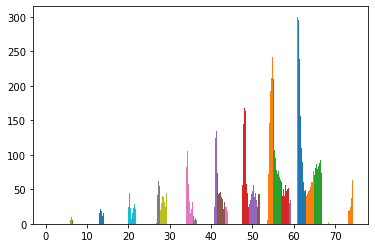

In [130]:
plt.plot()

In [159]:
n = 501
IM = abel.tools.analytical.SampleImage(n).image
origQ = abel.tools.symmetry.get_image_quadrants(IM)

In [170]:
origQ[1].shape

(251, 251)

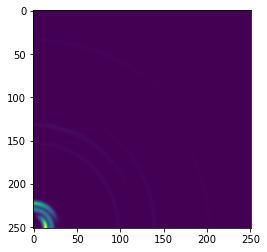

In [175]:
plt.imshow(origQ[1
        ])

begin draw_fft
data_fft_shifted_shape is : (300, 500)
vmax= 44304947.204358004
begin draw_fft
data_fft_shifted_shape is : (300, 500)
vmax= 47167430.943898275
delta = (0.5, 0.0)


<ipython-input-222-f12e00f0ade7>:114: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(ne),cmap = plt.cm.jet)


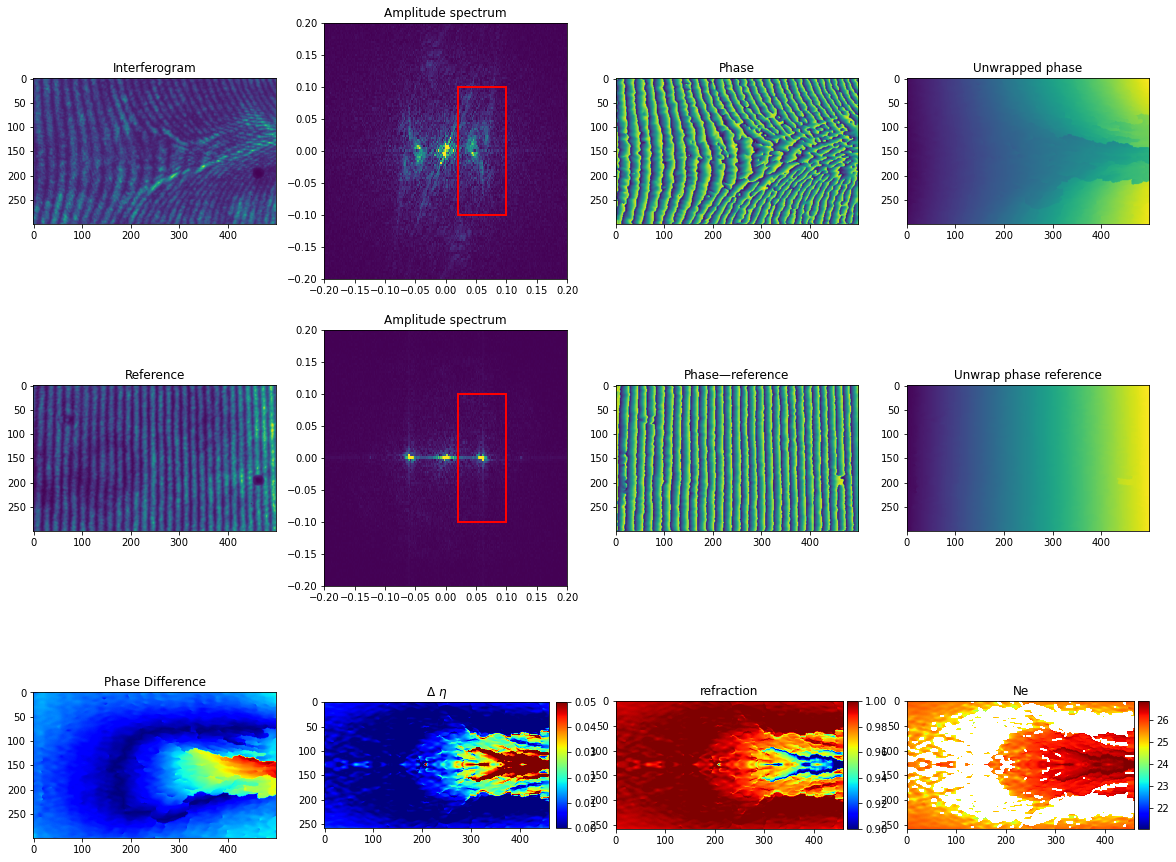

In [222]:
peak_threshold = 99
fx = 0.06
fy = 0.0
bands = [0.04,0.1]
crop = 50

filename = 'jet_data.tif'
data = np.array(Image.open(filename))

ny,nx = data.shape
#-----------------------Figure 1
figure = plt.figure(figsize=(20,16))
ax = figure.add_subplot(341)
ax.imshow(data)


#-----------------------Figure 2
ax.set_title('Interferogram')
ax = figure.add_subplot(342)
xfreq,yfreq,data_fft,data_fft_shifted,data_fft_shifted_mask = draw_fft(ax = ax,data = data,fx = fx,fy = fy,bands = bands)


#-----------------------Figure 3
ax = figure.add_subplot(343)
phase2 = np.angle(np.fft.ifftn(np.fft.ifftshift(data_fft_shifted_mask)))
ax.imshow(phase2)
ax.set_title('Phase')

#-----------------------Figure 4
ax = figure.add_subplot(344)
#由于相位在-pi到pi之间振荡，我们需要将其unwrapped，变为非振荡项
ax.set_title('Unwrapped phase')
crop = 20
phase_modify = unwrap_phase(phase2)
ax.imshow(phase_modify)


#对base图片做同样的操作
filename_base = 'jet_base.tif'
base_data = np.array(Image.open(filename_base))
ny,nx = base_data.shape

#-----------------------Figure 5
ax = figure.add_subplot(345)
ax.imshow(base_data)
ax.set_title('Reference')

#对参考图样做傅里叶变换

#-----------------------Figure 6
ax=figure.add_subplot(346)
x1,y1,basedata_fft,basedata_fft_shifted,basedata_fft_shifted_mask = draw_fft(ax = ax,data = base_data,fx = fx,fy = fy,bands = bands)

#逆傅里叶变换
#-----------------------Figure 7
ax=figure.add_subplot(347)
phase_ref = np.angle(np.fft.ifftn(np.fft.ifftshift(basedata_fft_shifted_mask)))
ax.imshow(phase_ref)
ax.set_title('Phase—reference')

#进行相位变换
#-----------------------Figure 8
ax=figure.add_subplot(348)
phase_ref_modify = unwrap_phase(phase_ref)
ax.imshow(phase_ref_modify)
ax.set_title('Unwrap phase reference')

#相减得到相位差
#-----------------------Figure 9
ax = figure.add_subplot(349)
phase_delta = abs(phase_modify - phase_ref_modify)
ax.imshow(phase_delta,cmap='jet')
ax.set_title('Phase Difference')

#对数密度进行反演，利用逆Abel变换
#-----------------------Figure 10
ax = figure.add_subplot(3,4,10)
ax.set_title(r'$\Delta \ \eta$')

#Flip the image
image = phase_delta.T/2/np.pi


inverse_abel = abel.Transform(image, method='three_point', direction='inverse', center='convolution',
                              symmetrize_method='average',verbose=True, symmetry_axis=0,
                             center_options={"axis" : 1, "verbose" : True}).transform.T

inverse_abel[inverse_abel < 0 ] = 0.0
inverse_abel[inverse_abel > 0.1 ] = 0.1
crop = 20
im = ax.imshow(inverse_abel[crop:-crop,crop:-crop],cmap = plt.cm.jet, vmin=0,vmax=0.05)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)

figure.colorbar(im, cax=cax, orientation='vertical')
#计算折射率
#-----------------------Figure 11
ax = figure.add_subplot(3,4,11)
ax.set_title('refraction')

eta = 1 - inverse_abel[crop:-crop,crop:-crop]
im = ax.imshow(eta,cmap = plt.cm.jet)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
figure.colorbar(im, cax=cax, orientation='vertical')

#计算数密度
wavelength = 0.547 # μm
nc = 1.1e21/((wavelength)**2)*1e6 #转为 m^-3

ne = nc * ( 1- eta**2)

ax = figure.add_subplot(3,4,12)
im = ax.imshow(np.log10(ne),cmap = plt.cm.jet)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
figure.colorbar(im, cax=cax, orientation='vertical')

#电子半径
# r_e = 2.81794e-15 #m
# sizePerPixel = 2.56*1e-6 #m
# Ne = inverse_abel / (r_e * wavelength*1e-6 * sizePerPixel)
# ax = figure.add_subplot(3,4,12)

# IM,ne,AIM = get_abel(phase=image,xcenter = 200,method = 'hansenlaw',gfactor = 1.0,wavelength = 527e-9)
# ax.imshow(Ne,cmap = plt.cm.seismic)

ax.set_title('Ne')

plt.savefig('test1.png',dpi=200)

(array([[290.,  10.,   0., ...,   0.,   0.,   0.],
        [291.,   9.,   0., ...,   0.,   0.,   0.],
        [291.,   9.,   0., ...,   0.,   0.,   0.],
        ...,
        [116., 116.,   0., ...,  19.,  15.,   0.],
        [119., 113.,   0., ...,  13.,  21.,   0.],
        [119., 113.,   0., ...,  10.,  24.,   0.]]),
 array([5.91676426e-09, 3.13340765e+02, 6.26681531e+02, 9.40022296e+02,
        1.25336306e+03, 1.56670383e+03, 1.88004459e+03, 2.19338536e+03,
        2.50672612e+03, 2.82006689e+03, 3.13340765e+03]),
 <a list of 500 Lists of Patches objects>)

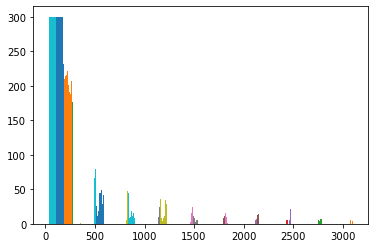

In [227]:
plt.hist(phase_delta**2)

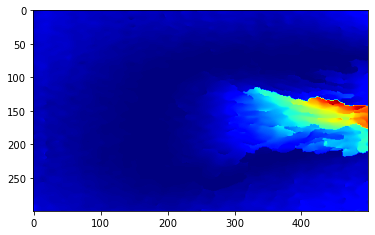

In [226]:
plt.imshow(phase_delta**2,cmap='jet')

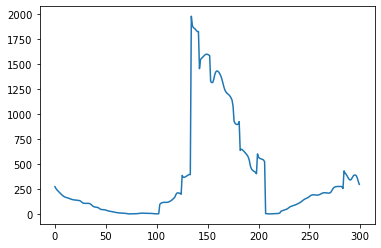

In [229]:
plt.plot(phase_delta[:,400]**2)

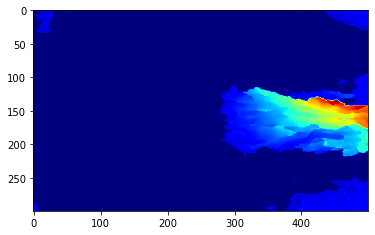

In [230]:
test = phase_delta**2
test[test < 250 ] = 1
plt.imshow(test,cmap='jet')

begin draw_fft
data_fft_shifted_shape is : (400, 500)
vmax= 46929105.66609929
begin draw_fft
data_fft_shifted_shape is : (400, 500)
vmax= 60612889.10120578
delta = (70.5, 0.0)


<ipython-input-370-a22259432e70>:113: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(ne),cmap = plt.cm.jet)


Text(0.5, 1.0, 'Ne')

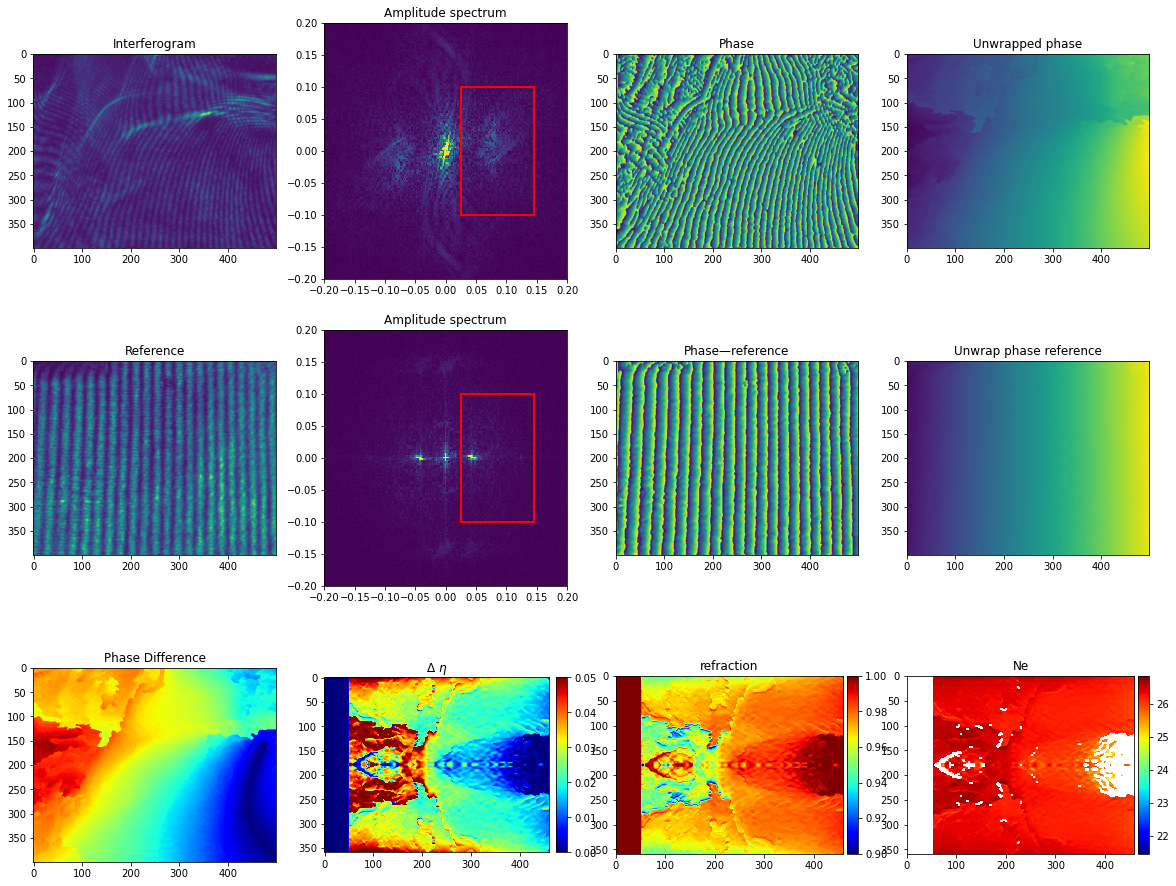

In [370]:
peak_threshold = 99
fx = 0.085
fy = 0.0
bands = [0.06,0.1]
crop = 50

filename = '20200901019_strongColide.tif'
data = np.array(Image.open(filename))[:,0:500]

ny,nx = data.shape
#-----------------------Figure 1
figure = plt.figure(figsize=(20,16))
ax = figure.add_subplot(341)
ax.imshow(data)


#-----------------------Figure 2
ax.set_title('Interferogram')
ax = figure.add_subplot(342)
xfreq,yfreq,data_fft,data_fft_shifted,data_fft_shifted_mask = draw_fft(ax = ax,data = data,fx = fx,fy = fy,bands = bands)


#-----------------------Figure 3
ax = figure.add_subplot(343)
phase2 = np.angle(np.fft.ifftn(np.fft.ifftshift(data_fft_shifted_mask)))
ax.imshow(phase2)
ax.set_title('Phase')

#-----------------------Figure 4
ax = figure.add_subplot(344)
#由于相位在-pi到pi之间振荡，我们需要将其unwrapped，变为非振荡项
ax.set_title('Unwrapped phase')
crop = 20
phase_modify = unwrap_phase(phase2)
ax.imshow(phase_modify)


#对base图片做同样的操作
filename_base = '20200901019_strongColide_back.tif'
base_data = np.array(Image.open(filename_base))[:,0:500]
ny,nx = base_data.shape

#-----------------------Figure 5
ax = figure.add_subplot(345)
ax.imshow(base_data)
ax.set_title('Reference')

#对参考图样做傅里叶变换

#-----------------------Figure 6
ax=figure.add_subplot(346)
x1,y1,basedata_fft,basedata_fft_shifted,basedata_fft_shifted_mask = draw_fft(ax = ax,data = base_data,fx = fx,fy = fy,bands = bands)

#逆傅里叶变换
#-----------------------Figure 7
ax=figure.add_subplot(347)
phase_ref = np.angle(np.fft.ifftn(np.fft.ifftshift(basedata_fft_shifted_mask)))
ax.imshow(phase_ref)
ax.set_title('Phase—reference')

#进行相位变换
#-----------------------Figure 8
ax=figure.add_subplot(348)
phase_ref_modify = unwrap_phase(phase_ref)
ax.imshow(phase_ref_modify)
ax.set_title('Unwrap phase reference')

#相减得到相位差
#-----------------------Figure 9
ax = figure.add_subplot(349)
phase_delta = abs(phase_modify - phase_ref_modify)
ax.imshow(phase_delta,cmap='jet')
ax.set_title('Phase Difference')

#对数密度进行反演，利用逆Abel变换
#-----------------------Figure 10
ax = figure.add_subplot(3,4,10)
ax.set_title(r'$\Delta \ \eta$')

#Flip the image
image = phase_delta.T/2/np.pi


inverse_abel = abel.Transform(image, method='three_point', direction='inverse', center='convolution',
                              symmetrize_method='average',verbose=True, symmetry_axis=0,
                             center_options={"axis" : 1, "verbose" : True}).transform.T

inverse_abel[inverse_abel < 0 ] = 0.0
inverse_abel[inverse_abel > 0.1 ] = 0.1
crop = 20
im = ax.imshow(inverse_abel[crop:-crop,crop:-crop],cmap = plt.cm.jet, vmin=0,vmax=0.05)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)

figure.colorbar(im, cax=cax, orientation='vertical')
#计算折射率
#-----------------------Figure 11
ax = figure.add_subplot(3,4,11)
ax.set_title('refraction')

eta = 1 - inverse_abel[crop:-crop,crop:-crop]
im = ax.imshow(eta,cmap = plt.cm.jet)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
figure.colorbar(im, cax=cax, orientation='vertical')

#计算数密度
wavelength = 0.547 # μm
nc = 1.1e21/((wavelength)**2)*1e6 #转为 m^-3
ne = nc * ( 1- eta**2)

ax = figure.add_subplot(3,4,12)
im = ax.imshow(np.log10(ne),cmap = plt.cm.jet)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
figure.colorbar(im, cax=cax, orientation='vertical')

#电子半径
# r_e = 2.81794e-15 #m
# sizePerPixel = 2.56*1e-6 #m
# Ne = inverse_abel / (r_e * wavelength*1e-6 * sizePerPixel)
# ax = figure.add_subplot(3,4,12)

# IM,ne,AIM = get_abel(phase=image,xcenter = 200,method = 'hansenlaw',gfactor = 1.0,wavelength = 527e-9)
# ax.imshow(Ne,cmap = plt.cm.seismic)

ax.set_title('Ne')

#plt.savefig('test1.png',dpi=200)

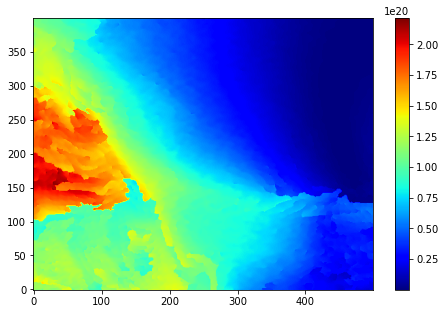

In [383]:
plt.figure(figsize=(8,5))
ne = 2*phase_delta**2*nc*wavelength/1500/2/100
plt.imshow(np.l(ne/1e6),cmap='jet',origin='lower')
plt.colorbar()

begin draw_fft
data_fft_shifted_shape is : (600, 700)
vmax= 79266591.87389915
begin draw_fft
data_fft_shifted_shape is : (600, 700)
vmax= 157232290.54326332
delta = (103.5, 0.0)


<ipython-input-359-472155617296>:113: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(ne),cmap = plt.cm.jet)


Text(0.5, 1.0, 'Ne')

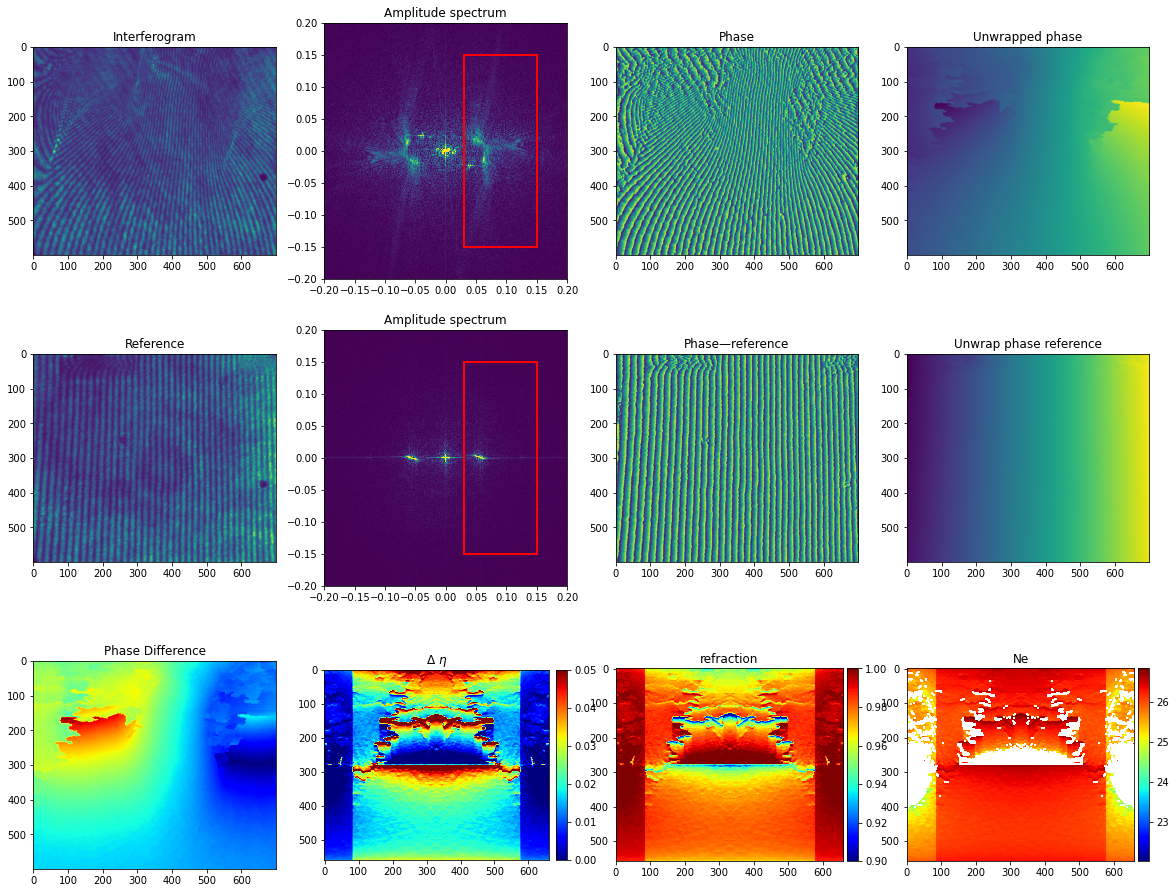

In [359]:
peak_threshold = 99
fx = 0.09
fy = 0.0
bands = [0.06,0.15]
crop = 50

filename = '20200829010_ganshe_cut.tif'
data = np.array(Image.open(filename))

ny,nx = data.shape
#-----------------------Figure 1
figure = plt.figure(figsize=(20,16))
ax = figure.add_subplot(341)
ax.imshow(data)


#-----------------------Figure 2
ax.set_title('Interferogram')
ax = figure.add_subplot(342)
xfreq,yfreq,data_fft,data_fft_shifted,data_fft_shifted_mask = draw_fft(ax = ax,data = data,fx = fx,fy = fy,bands = bands)


#-----------------------Figure 3
ax = figure.add_subplot(343)
phase2 = np.angle(np.fft.ifftn(np.fft.ifftshift(data_fft_shifted_mask)))
ax.imshow(phase2)
ax.set_title('Phase')

#-----------------------Figure 4
ax = figure.add_subplot(344)
#由于相位在-pi到pi之间振荡，我们需要将其unwrapped，变为非振荡项
ax.set_title('Unwrapped phase')
crop = 20
phase_modify = unwrap_phase(phase2)
ax.imshow(phase_modify)


#对base图片做同样的操作
filename_base = '20200829010_ganshe_back_cut.tif'
base_data = np.array(Image.open(filename_base))
ny,nx = base_data.shape

#-----------------------Figure 5
ax = figure.add_subplot(345)
ax.imshow(base_data)
ax.set_title('Reference')

#对参考图样做傅里叶变换

#-----------------------Figure 6
ax=figure.add_subplot(346)
x1,y1,basedata_fft,basedata_fft_shifted,basedata_fft_shifted_mask = draw_fft(ax = ax,data = base_data,fx = fx,fy = fy,bands = bands)

#逆傅里叶变换
#-----------------------Figure 7
ax=figure.add_subplot(347)
phase_ref = np.angle(np.fft.ifftn(np.fft.ifftshift(basedata_fft_shifted_mask)))
ax.imshow(phase_ref)
ax.set_title('Phase—reference')

#进行相位变换
#-----------------------Figure 8
ax=figure.add_subplot(348)
phase_ref_modify = unwrap_phase(phase_ref)
ax.imshow(phase_ref_modify)
ax.set_title('Unwrap phase reference')

#相减得到相位差
#-----------------------Figure 9
ax = figure.add_subplot(349)
phase_delta = abs(phase_modify - phase_ref_modify)
ax.imshow(phase_delta,cmap='jet')
ax.set_title('Phase Difference')

#对数密度进行反演，利用逆Abel变换
#-----------------------Figure 10
ax = figure.add_subplot(3,4,10)
ax.set_title(r'$\Delta \ \eta$')

#Flip the image
image = phase_delta.T/2/np.pi


inverse_abel = abel.Transform(image, method='three_point', direction='inverse', center='convolution',
                              symmetrize_method='average',verbose=True, symmetry_axis=1,
                             center_options={"axis" : 1, "verbose" : True}).transform.T

inverse_abel[inverse_abel < 0 ] = 0.0
inverse_abel[inverse_abel > 0.1 ] = 0.1
crop = 20
im = ax.imshow(inverse_abel[crop:-crop,crop:-crop],cmap = plt.cm.jet, vmin=0,vmax=0.05)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)

figure.colorbar(im, cax=cax, orientation='vertical')
#计算折射率
#-----------------------Figure 11
ax = figure.add_subplot(3,4,11)
ax.set_title('refraction')

eta = 1 - inverse_abel[crop:-crop,crop:-crop]
im = ax.imshow(eta,cmap = plt.cm.jet)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
figure.colorbar(im, cax=cax, orientation='vertical')

#计算数密度
wavelength = 0.547 # μm
nc = 1.1e21/((wavelength)**2)*1e6 #转为 m^-3
ne = nc * ( 1- eta**2)

ax = figure.add_subplot(3,4,12)
im = ax.imshow(np.log10(ne),cmap = plt.cm.jet)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
figure.colorbar(im, cax=cax, orientation='vertical')

#电子半径
# r_e = 2.81794e-15 #m
# sizePerPixel = 2.56*1e-6 #m
# Ne = inverse_abel / (r_e * wavelength*1e-6 * sizePerPixel)
# ax = figure.add_subplot(3,4,12)

# IM,ne,AIM = get_abel(phase=image,xcenter = 200,method = 'hansenlaw',gfactor = 1.0,wavelength = 527e-9)
# ax.imshow(Ne,cmap = plt.cm.seismic)

ax.set_title('Ne')

#plt.savefig('test1.png',dpi=200)

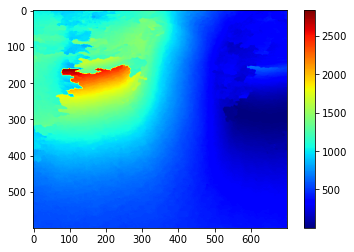

In [265]:
plt.imshow(phase_delta**1.5,cmap='jet')
plt.colorbar()

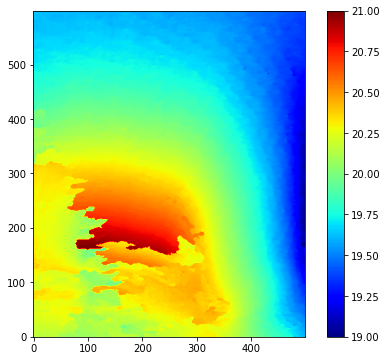

In [362]:
plt.figure(figsize=(8,6))
ne = 2*phase_delta**3*nc*wavelength/1500/2/10000
plt.imshow(np.log10(ne[:,0:500]/1e6),cmap='jet',vmin=19,vmax=21,origin='lower')
plt.colorbar()

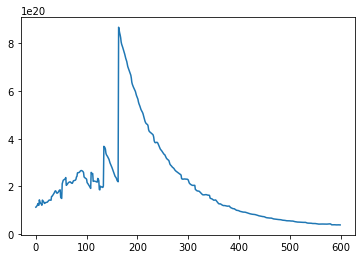

In [363]:
plt.plot(ne[:,200]/1e6)

begin draw_fft
data_fft_shifted_shape is : (200, 450)
vmax= 22859489.15965914
begin draw_fft
data_fft_shifted_shape is : (200, 450)
vmax= 53208607.921637654
delta = (-21.5, -20.0)


Text(0.5, 1.0, 'Ne')

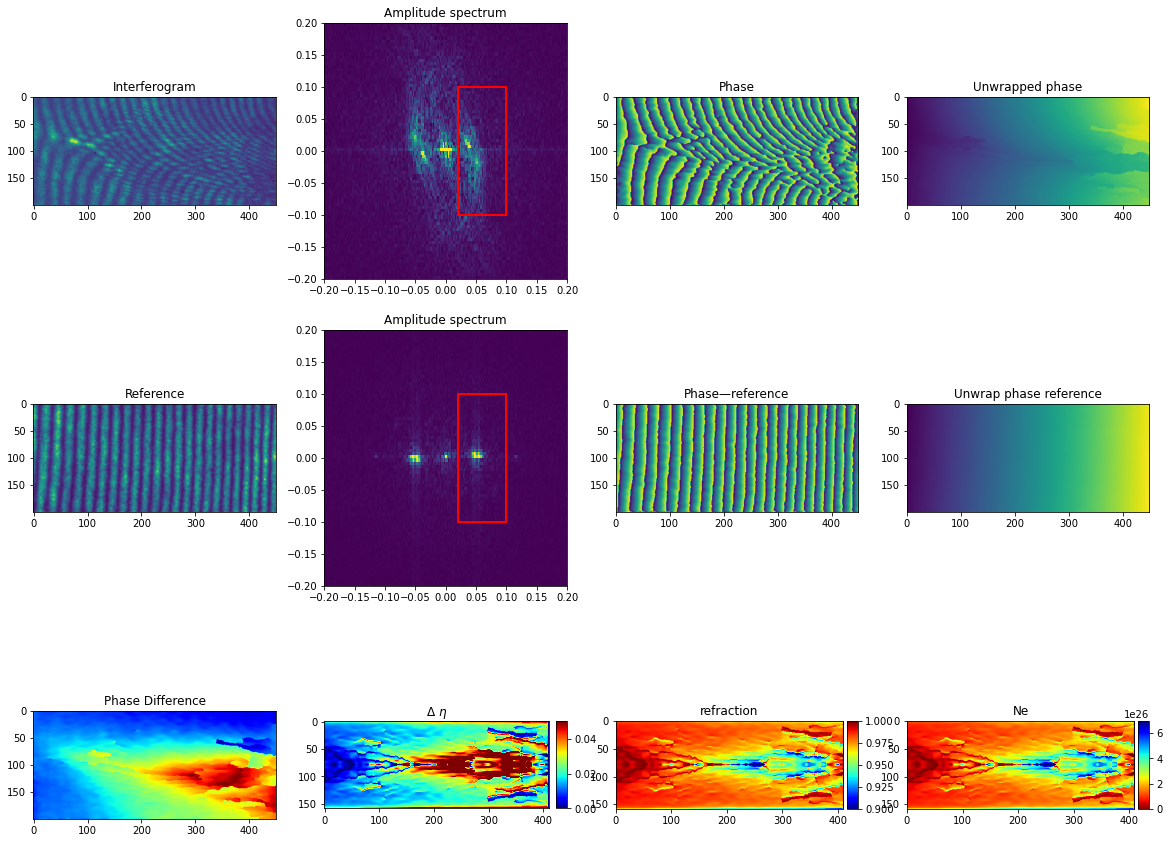

In [340]:
peak_threshold = 99
fx = 0.06
fy = 0.0
bands = [0.04,0.10]
crop = 50

filename = '20200829009_ganshe_cut.tif'
data = np.array(Image.open(filename))

ny,nx = data.shape
#-----------------------Figure 1
figure = plt.figure(figsize=(20,16))
ax = figure.add_subplot(341)
ax.imshow(data)


#-----------------------Figure 2
ax.set_title('Interferogram')
ax = figure.add_subplot(342)
xfreq,yfreq,data_fft,data_fft_shifted,data_fft_shifted_mask = draw_fft(ax = ax,data = data,fx = fx,fy = fy,bands = bands)


#-----------------------Figure 3
ax = figure.add_subplot(343)
phase2 = np.angle(np.fft.ifftn(np.fft.ifftshift(data_fft_shifted_mask)))
ax.imshow(phase2)
ax.set_title('Phase')

#-----------------------Figure 4
ax = figure.add_subplot(344)
#由于相位在-pi到pi之间振荡，我们需要将其unwrapped，变为非振荡项
ax.set_title('Unwrapped phase')
crop = 20
phase_modify = unwrap_phase(phase2)
ax.imshow(phase_modify)


#对base图片做同样的操作
filename_base = '20200829008_ganshe_back_cut.tif'
base_data = np.array(Image.open(filename_base))
ny,nx = base_data.shape

#-----------------------Figure 5
ax = figure.add_subplot(345)
ax.imshow(base_data)
ax.set_title('Reference')

#对参考图样做傅里叶变换

#-----------------------Figure 6
ax=figure.add_subplot(346)
x1,y1,basedata_fft,basedata_fft_shifted,basedata_fft_shifted_mask = draw_fft(ax = ax,data = base_data,fx = fx,fy = fy,bands = bands)

#逆傅里叶变换
#-----------------------Figure 7
ax=figure.add_subplot(347)
phase_ref = np.angle(np.fft.ifftn(np.fft.ifftshift(basedata_fft_shifted_mask)))
ax.imshow(phase_ref)
ax.set_title('Phase—reference')

#进行相位变换
#-----------------------Figure 8
ax=figure.add_subplot(348)
phase_ref_modify = unwrap_phase(phase_ref)
ax.imshow(phase_ref_modify)
ax.set_title('Unwrap phase reference')

#相减得到相位差
#-----------------------Figure 9
ax = figure.add_subplot(349)
phase_delta = abs(phase_modify - phase_ref_modify)
phase_delta = phase_delta - phase_delta.max()
phase_delta = abs(phase_delta)
ax.imshow(phase_delta,cmap='jet')
ax.set_title('Phase Difference')

#对数密度进行反演，利用逆Abel变换
#-----------------------Figure 10
ax = figure.add_subplot(3,4,10)
ax.set_title(r'$\Delta \ \eta$')

#Flip the image
image = phase_delta.T/2/np.pi


inverse_abel = abel.Transform(image, method='three_point', direction='inverse', center='convolution',
                              symmetrize_method='average',verbose=True, symmetry_axis=0,
                             center_options={"axis" : 1, "verbose" : True}).transform.T

inverse_abel[inverse_abel < 0 ] = 0.0
inverse_abel[inverse_abel > 0.1 ] = 0.1
crop = 20
im = ax.imshow(inverse_abel[crop:-crop,crop:-crop],cmap = plt.cm.jet, vmin=0,vmax=0.05)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)

figure.colorbar(im, cax=cax, orientation='vertical')
#计算折射率
#-----------------------Figure 11
ax = figure.add_subplot(3,4,11)
ax.set_title('refraction')

eta = 1 - inverse_abel[crop:-crop,crop:-crop]
im = ax.imshow(eta,cmap = plt.cm.jet)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
figure.colorbar(im, cax=cax, orientation='vertical')

#计算数密度
wavelength = 0.547 # μm
nc = 1.1e21/((wavelength)**2)*1e6 #转为 m^-3
ne = nc * ( 1- eta**2)

ax = figure.add_subplot(3,4,12)
im = ax.imshow((ne),cmap = plt.cm.jet_r)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
figure.colorbar(im, cax=cax, orientation='vertical')

#电子半径
# r_e = 2.81794e-15 #m
# sizePerPixel = 2.56*1e-6 #m
# Ne = inverse_abel / (r_e * wavelength*1e-6 * sizePerPixel)
# ax = figure.add_subplot(3,4,12)

# IM,ne,AIM = get_abel(phase=image,xcenter = 200,method = 'hansenlaw',gfactor = 1.0,wavelength = 527e-9)
# ax.imshow(Ne,cmap = plt.cm.seismic)

ax.set_title('Ne')

#plt.savefig('test1.png',dpi=200)

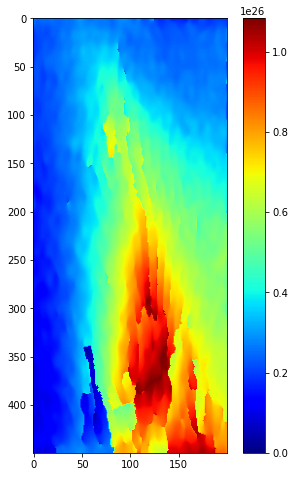

In [357]:
plt.figure(figsize=(6,8))
ne = 2*phase_delta*nc*wavelength/250/2/3
plt.imshow(ne.T,cmap='jet')
plt.colorbar()

<ipython-input-336-ae21ca6fc39d>:2: RuntimeWarning: divide by zero encountered in log10
  test[(np.where((np.log10(test)) == np.log10(0)))] = 1e28


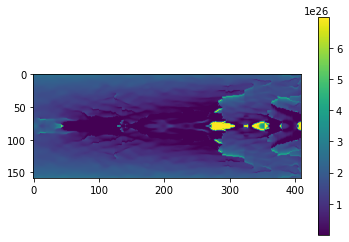

In [336]:
test = ne
test[(np.where((np.log10(test)) == np.log10(0)))] = 1e2
plt.imshow(test)
plt.colorbar()

In [331]:
np.where((np.log10(test)) == np.log10(0))

<ipython-input-331-9afb16d9698f>:1: RuntimeWarning: divide by zero encountered in log10
  np.where((np.log10(test)) == np.log10(0))


(array([ 25,  25,  25, ..., 133, 133, 133]),
 array([287, 288, 289, ..., 313, 314, 315]))

In [328]:
np.log10(0)

<ipython-input-328-fb8478a94c6a>:1: RuntimeWarning: divide by zero encountered in log10
  np.log10(0)


-inf